**Phoneme vs. Silence Model**

The code below trains a Phoneme vs. Silence classfier model on all the 16 subject data. There are four different RNN models and a Gaussian Bayes model. 

In [41]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [42]:
!pip install mne

In [43]:
#import packages
import mne # For loading EEG data
import numpy as np
import glob 
import os
import csv

from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
%matplotlib inline


In [44]:
#unique phonemes from Phoneme data
sub = ['MT0001'] 
data_dir = '/content/drive/My Drive'
for su in sub:
    timit_filename = data_dir + '/EEG_Phonemes /'+ su + '_TIMIT_phn_info.txt'   
    
    f_timit = open(timit_filename, "r")
    lines = f_timit.readlines()
    phoneme = []
    for x in range(len(lines)):
      #print(len(lines[x].strip('\t\t')))
      phoneme.append(lines[x][:3].strip('\t'))
    print(len(set(phoneme)))

51


In [45]:
# 'pau', h# and 'epi are silences
class_phn = {}
class_phn.update(dict.fromkeys(['pau', 'h#', 'epi'],1))


In [46]:
class_phn

{'epi': 1, 'h#': 1, 'pau': 1}

In [47]:
#files limited by MT0001
train = ['MT0001']
for num,subject in enumerate(train):
    timit_phn_filename = data_dir + '/EEG_Phonemes /'+ subject + '_TIMIT_phn_info.txt'
    print(subject)
   
    with open(timit_phn_filename) as inf:
        reader = csv.reader(inf, delimiter='\t')
        second_col = list(zip(*reader))
        phonemes = np.array(second_col[0])
        start_time = np.array(second_col[2])
        wav_title = second_col[6]

    timit_filename = data_dir + '/EEG_LSTM/'+ subject + 'timit/'#.npy' 

    for root, dirs, files in os.walk(timit_filename, topdown=False):
      
      # for each wav file for a subject
      female = 0
      male = 0
      count = 0

      files = os.listdir(timit_filename)
      files = sorted(files)
      print(files)
final_files = np.array(files) 

import random
test_list = random.sample(range(380), 80)
train_list = [i for i in range(380) if i not in test_list]
print(len(test_list), len(train_list))



train_files = final_files[train_list]
test_files = final_files[test_list]

MT0001
['fadg0_si1279.npy', 'faem0_si2022.npy', 'falr0_si1955.npy', 'fbcg1_si1612.npy', 'fbjl0_si2182.npy', 'fbmh0_si1766.npy', 'fbmj0_si815.npy', 'fcag0_si1503.npy', 'fcag0_si1641.npy', 'fcaj0_si1479.npy', 'fcaj0_si1804.npy', 'fceg0_si1878.npy', 'fceg0_si618.npy', 'fcft0_si1808.npy', 'fcft0_si548.npy', 'fcjs0_si1607.npy', 'fcmh0_si2084.npy', 'fcmh1_si1493.npy', 'fcmr0_si1735.npy', 'fcmr0_si475.npy', 'fcrh0_si1718.npy', 'fcrz0_si2053.npy', 'fdas1_si2091.npy', 'fdaw0_si1406.npy', 'fdfb0_si1948.npy', 'fdhc0_si2189.npy', 'fdjh0_si1565.npy', 'fdml0_si2075.npy', 'fdms0_si1218.npy', 'fdrd1_si1544.npy', 'fdrw0_si1423.npy', 'fdxw0_si1511.npy', 'fdxw0_si2141.npy', 'feac0_si1245.npy', 'fear0_si1882.npy', 'fedw0_si1653.npy', 'fetb0_si1148.npy', 'fgcs0_si856.npy', 'fgjd0_si1179.npy', 'fgmd0_si2107.npy', 'fgrw0_si1990.npy', 'fhlm0_si1560.npy', 'fisb0_si2209.npy', 'fjas0_si2030.npy', 'fjhk0_si1652.npy', 'fjkl0_si1562.npy', 'fjkl0_si2192.npy', 'fjlg0_si1506.npy', 'fjlg0_si2306.npy', 'fjlr0_si1861.npy

In [48]:
train = ['MT0001','MT0002', 'MT0003','MT0004','MT0005','MT0006', 'MT0008','MT0009','MT0010', 'MT0011', 'MT0012', 'MT0013', 'MT0014', 'MT0015', 'MT0016', 'MT0017']

train_frames = []
test_frames = []

train_label = []
test_label = []

for num,subject in enumerate(train):
    timit_phn_filename = data_dir + '/EEG_Phonemes /'+ subject + '_TIMIT_phn_info.txt' #timing information for phonemes generated by praat tool

    female = 0
    male = 0

    
    with open(timit_phn_filename) as inf:
        reader = csv.reader(inf, delimiter='\t')
        second_col = list(zip(*reader))
        phonemes = np.array(second_col[0])
        start_time = np.array(second_col[2])
        wav_title = second_col[6]
    



    timit_filename = data_dir + '/EEG_LSTM/'+ subject + 'timit/'#.npy'

    for root, dirs, files in os.walk(timit_filename, topdown=False):
      # for each wav file for a subject
      count = 0
      files = os.listdir(timit_filename)
      files = sorted(files)

      
      for name in files:
          if name[0] == 'm':
            male = male + 1
          else:
            female = female + 1
          #print(male, female)

          count = count + 1
          
          timit_file = os.path.join(root, name)
          timit = np.load(timit_file)
          #print(name)
          indexes = []
          #Append row nums for that wav_title from events file
          for x in range(len(wav_title)):
            if name[:-4] == wav_title[x]:
              indexes.append(x)
          
          # Take only the first wav file from eventsfile 
          for ele in range(len(indexes)-1):
            if indexes[ele+1] - indexes[ele] > 1:
              indexes = np.array(indexes[:ele])
              break
          
          if len(indexes) == 0:
            print("skipping:", name)
            continue

          phon = phonemes[indexes]
          start = np.array(start_time[indexes], dtype=int)
          frames = np.zeros((phon.shape[0],20,64))
          timit = timit.reshape(timit.shape[1], timit.shape[2])
          timit = timit.T


          timit = timit[65:, :] #removing 0.5s of past EEG data
          

          for p in range(len(phon)-1):
              beg = start[p] - start[0]
              end = start[p+1] - start[0]
              timit_len = end - beg
              if timit_len < 19:
                bal_l = 4
                bal_r = 20 - timit_len - bal_l # subtract timit len and bal_l from total_len 
                total = end+bal_r - (beg - bal_l)
                #print("beg, end, timit_len, bal, total", beg, end, timit_len, bal, total)
                if beg - bal_l < 0:
                  frames[p,:total - bal_l,:64] = timit[beg : end+bal_r,:]
                else:
                  frames[p,:total,:64] = timit[beg-bal_l : end+bal_r,:]
              elif timit_len > 20:
                frames[p,:20,:64] = timit[beg: beg+20, :]
              else:
                frames[p,:timit_len,:64] = timit[beg:end, :]
          #fill the last phoneme from end:20   
          frames[len(phon)-1,:, :64] = timit[end: end+20, :]
          #break


          y_label = []
          for phn_num,p in enumerate(phon):
            if (phn_num == 0 or phn_num == len(phon) -1) and p == 'h':
                y_label.append(class_phn['h#'])
            elif p == 'pau':
              y_label.append(class_phn['pau'])
            elif p == 'epi':
              y_label.append(class_phn['epi'])
            else:
                y_label.append(0)

         
          if name in train_files:
            train_frames.append(frames)
            train_label.append(y_label)
            #print("train", name)
            
          elif name in test_files:
            test_frames.append(frames)
            test_label.append(y_label)
            #print("test", name)
          else:
            print("not train or test")


          #break


skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mjjb0_si1277.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy
skipping: mchh0_si1634.npy
skipping: mkcl0_si1721.npy


In [49]:
train_frames_ = np.concatenate(train_frames, axis = 0)
train_label_ = np.concatenate(train_label, axis = 0)

test_frames_ = np.concatenate(test_frames, axis = 0)
test_label_ = np.concatenate(test_label, axis = 0)

In [50]:
from collections import Counter
print(Counter(test_label_).keys()) # equals to list(set(words))
print(Counter(test_label_).values()) # counts the elements' frequency

print(Counter(train_label_).keys()) # equals to list(set(words))
print(Counter(train_label_).values()) # counts the elements' frequency

dict_keys([1, 0])
dict_values([2273, 28651])
dict_keys([1, 0])
dict_values([9154, 111322])


In [51]:
pca_case = False
#reshape train_frames_
train_1 = train_frames_.shape[0]
test_1 = test_frames_.shape[0]
train_frames_ = np.reshape(train_frames_, ((train_frames_.shape[0]*20,64)))
test_frames_ = np.reshape(test_frames_, ((test_frames_.shape[0]*20,64)))



#standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_frames_)
train_frames_ = scaler.transform(train_frames_)
test_frames_ = scaler.transform(test_frames_)

#PCA
n_components = 64
if pca_case:
  pca = decomposition.PCA(n_components=n_components)
  pca.fit(train_frames_)
  train_frames_pca = pca.transform(train_frames_)
  test_frames_pca = pca.transform(test_frames_)
  train_frames_pca = np.reshape(train_frames_pca, ((train_1,20,n_components)))
  test_frames_pca = np.reshape(test_frames_pca, ((test_1,20,n_components)))



else:
  train_frames_ = np.reshape(train_frames_, ((train_1,20,n_components)))
  test_frames_ = np.reshape(test_frames_, ((test_1,20,n_components)))




In [52]:
#calculate test % data
print(test_frames_.shape[0]/(test_frames_.shape[0]+train_frames_.shape[0]))

0.20425363276089828


In the below sections, we train 4 RNN models and Bayes model

In [18]:
#Final experiments-final - LSTM - PCA


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Dropout, BatchNormalization, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

model = Sequential()
model.add(LSTM(256, input_shape=(train_frames_.shape[1],train_frames_.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
print(model.summary())
model.fit(train_frames_pca, train_label_, epochs=50, batch_size=64, verbose = 1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 256)           328704    
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 256)           1024      
_________________________________________________________________
activation (Activation)      (None, 20, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 855,297
Trainable params: 854,785
Non-trainable params: 512
________________________________________________

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


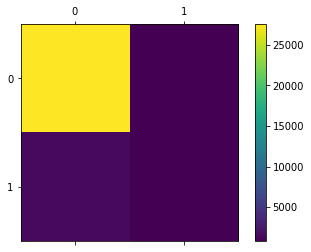

[[27574   786]
 [ 1490   861]]
(0.7357512495506431, 0.6692560228549626, 0.6955401809291383, None)


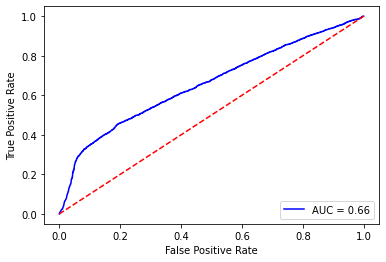

In [19]:
actual = model.predict(test_frames_pca)
predict = actual
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
#predict = np.argmax(actual, axis=1)
test_label_ = np.concatenate(test_label, axis = 0)
print(predict)

#test_label_ = np.argmax(actual, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_label_, predict)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.show()

print(cm)
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(test_label_, predict, average='macro'))

actual = model.predict(test_frames_)
import sklearn.metrics as metrics

fpr, tpr, thresholds = metrics.roc_curve(test_label_, actual)#, pos_label=1)
#print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
#Final experiments-final - GRU - PCA

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Dropout, BatchNormalization, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

model = Sequential()
model.add(GRU(256, input_shape=(train_frames_.shape[1],train_frames_.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(GRU(256))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
print(model.summary())
model.fit(train_frames_pca, train_label_, epochs=50, batch_size=64, verbose = 1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20, 256)           247296    
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 256)           1024      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 256)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 643,329
Trainable params: 642,817
Non-trainable params: 512
______________________________________________

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


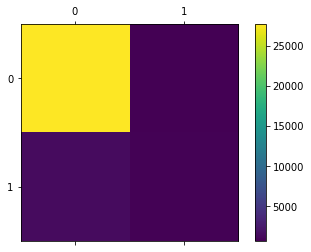

[[27692   668]
 [ 1489   862]]
(0.7561861700233364, 0.6715490932346407, 0.7033645471467168, None)


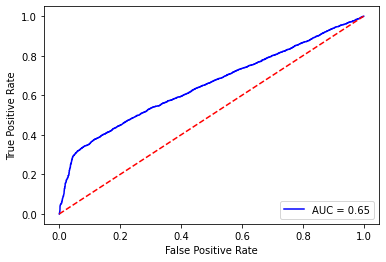

In [21]:
actual = model.predict(test_frames_pca)
predict = actual
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
#predict = np.argmax(actual, axis=1)
test_label_ = np.concatenate(test_label, axis = 0)
print(predict)

#test_label_ = np.argmax(actual, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_label_, predict)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.show()

print(cm)
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(test_label_, predict, average='macro'))

actual = model.predict(test_frames_)
import sklearn.metrics as metrics

fpr, tpr, thresholds = metrics.roc_curve(test_label_, actual)#, pos_label=1)
#print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [28]:
#Final experiments-final - LSTM - no-PCA


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Dropout, BatchNormalization, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

model = Sequential()
model.add(LSTM(256, input_shape=(train_frames_.shape[1],train_frames_.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
print(model.summary())
model.fit(train_frames_, train_label_, epochs=50, batch_size=64, verbose = 1)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 256)           328704    
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 256)           1024      
_________________________________________________________________
activation_2 (Activation)    (None, 20, 256)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 855,297
Trainable params: 854,785
Non-trainable params: 512
______________________________________________

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


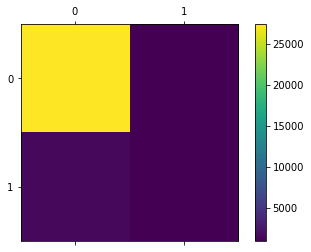

[[27431   929]
 [ 1476   875]]
(0.7169864813047914, 0.6697123226979607, 0.6895915194636764, None)


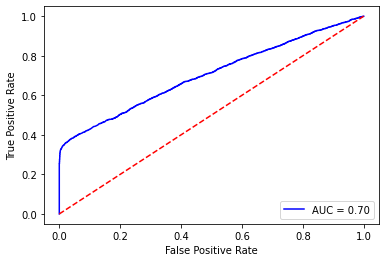

In [29]:
actual = model.predict(test_frames_)
predict = actual
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
#predict = np.argmax(actual, axis=1)
test_label_ = np.concatenate(test_label, axis = 0)
print(predict)

#test_label_ = np.argmax(actual, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_label_, predict)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.show()

print(cm)
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(test_label_, predict, average='macro'))

actual = model.predict(test_frames_)
import sklearn.metrics as metrics

fpr, tpr, thresholds = metrics.roc_curve(test_label_, actual)#, pos_label=1)
#print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
#Final experiments-final - GRU - no-PCA

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Dropout, BatchNormalization, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

model = Sequential()
model.add(GRU(256, input_shape=(train_frames_.shape[1],train_frames_.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(GRU(256))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
print(model.summary())
model.fit(train_frames_, train_label_, epochs=50, batch_size=64, verbose = 1)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 20, 256)           247296    
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 256)           1024      
_________________________________________________________________
activation_3 (Activation)    (None, 20, 256)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 643,329
Trainable params: 642,817
Non-trainable params: 512
______________________________________________

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


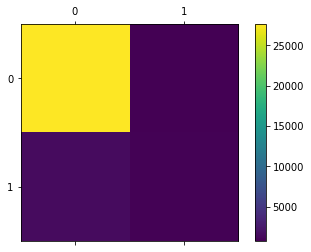

[[27674   686]
 [ 1493   858]]
(0.7522557477211363, 0.6703810430276346, 0.7013434803276948, None)


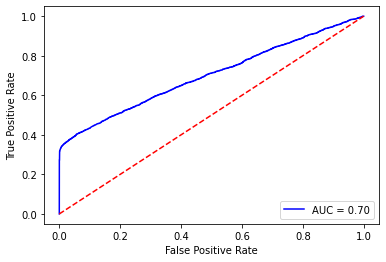

In [31]:
actual = model.predict(test_frames_)
predict = actual
predict[predict >= 0.5] = 1
predict[predict < 0.5] = 0
#predict = np.argmax(actual, axis=1)
test_label_ = np.concatenate(test_label, axis = 0)
print(predict)

#test_label_ = np.argmax(actual, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_label_, predict)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.show()

print(cm)
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(test_label_, predict, average='macro'))

actual = model.predict(test_frames_)
import sklearn.metrics as metrics

fpr, tpr, thresholds = metrics.roc_curve(test_label_, actual)#, pos_label=1)
#print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Bayes Model**

In [38]:
train_frames_ = np.reshape(train_frames_, ((train_frames_.shape[0]*20,64)))
test_frames_ = np.reshape(test_frames_, ((test_frames_.shape[0]*20,64)))

#naive bayes filling the label
train_l_ = np.zeros((train_frames_.shape[0]))
test_l_ = np.zeros((test_frames_.shape[0]))

for i in range(train_label_.shape[0]):
  train_l_[i*20:i*20+20] = train_label_[i]

for i in range(test_label_.shape[0]):
  test_l_[i*20:i*20+20] = test_label_[i]


In [39]:
from collections import Counter
print(Counter(test_l_).keys()) # equals to list(set(words))
print(Counter(test_l_).values()) # counts the elements' frequency

print(Counter(train_l_).keys()) # equals to list(set(words))
print(Counter(train_l_).values()) # counts the elements' frequency

dict_keys([1.0, 0.0])
dict_values([48180, 583200])
dict_keys([1.0, 0.0])
dict_values([180360, 2216260])


(0.524444163474668, 0.5006441849579851, 0.48276217067594634, None)


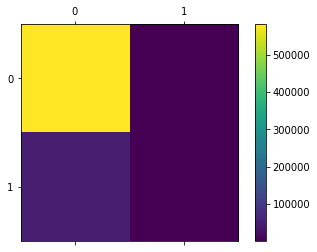

[[582172   1028]
 [ 48033    147]]


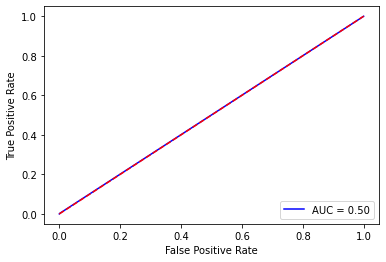

In [40]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(train_frames_, train_l_).predict(test_frames_)
accuracy_score(y_pred, test_l_)

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(test_l_, y_pred, average='macro'))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_l_, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.show()

print(cm)

import sklearn.metrics as metrics

fpr, tpr, thresholds = metrics.roc_curve(test_l_, y_pred)#, pos_label=1)
#print(fpr, tpr, thresholds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()